In [4]:
# Import packages
import numpy
import scipy
import pandas
from matplotlib import pyplot
from scipy.interpolate import griddata
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.basemap import Basemap

## Part 1 - Reading the file and analyzing it

In [5]:
# There are six channels and a tab delimitation. Besides we have to skip one single row.
Long, Lat, Tf = numpy.loadtxt('real-data/cabofrio.dat', skiprows = 0, usecols=(2,3,4), unpack = True)

In [6]:
# Define the area
geografic_area = (Long.min(), Long.max(), Lat.min(), Lat.max())
#projected_area = (X.min(), X.max(), Y.min(), Y.max())

In [7]:
print 'Study area (degrees):', numpy.round(geografic_area, decimals = 3)

Study area (degrees): [-42.05 -41.94 -23.05 -22.92]


In [8]:
# Define the minimum and maximum values
longmin = numpy.round(Long.min(), decimals = 2)
longmax = numpy.round(Long.max(), decimals = 2)
latmin = numpy.round(Lat.min(), decimals = 2)
latmax = numpy.round(Lat.max(), decimals = 2)

In [9]:
# Analysing the total field anomaly data
print 'Total field anomaly data:'
print 'Min:', Tf.min()
print 'Max:', Tf.max()

Total field anomaly data:
Min: -724.716
Max: 243.795


## Part 2 - Interpolate the data and drawing the basemap

In [10]:
# Define number of points and shape
num = 500
longitude = numpy.linspace(longmin, longmax, num)
latitude = numpy.linspace(latmin, latmax, num)

In [11]:
# Creates the grid
gridlong, gridlat = numpy.meshgrid(longitude, latitude)

In [12]:
# Create the tuples
flightcoordinates = (Long, Lat)
gridcoordinates = (gridlong, gridlat)

In [13]:
# Interpolate the total field anomaly data and also the magnetic field intensity
Tfi = griddata(flightcoordinates, Tf, gridcoordinates, method = 'linear')

In [14]:
# Setting values for colorbar:
vtfmin = Tf.min()
vtfmax = Tf.max()

In [15]:
# Setting the central values
long0 = 0.5*(longmin + longmax)
lat0 = 0.5*(latmin + latmax)

## Part 3 - Interpolation to apply cross-correlation

In [16]:
# Import usefull libraries
from utm import from_latlon
from codes.grids import regular_grid
from codes.statistical import cccoef
from codes.filtering import reduction
from codes.derivative import totalgrad, zderiv
# Modules for equivalent layer
from codes.equivalentlayer import layer, fit_layer, rtp_layer

Here we will work with projected coordinates 

In [17]:
# Find the utm zone of all data:
pp = []
for k in range(Long.size):
    l = from_latlon(Lat[k], Long[k])
    pp.append(l[2])

In [18]:
# Show the zone number
numpy.min(pp), numpy.max(pp)

(23, 24)

# Here we will apply our fisrt test: the calculation of geographic coordinates into projected coordinates to UTM Zone 23 and 24

In [19]:
# Define the grid informations
shape = (40, 40)
h = -150.

In [20]:
Lx = []
Ly = []
xy = []
corners = [-42.02, -41.97, -23.03, -22.99]

In [21]:
# Salvar os dados de Arraial do Cabo
arraialdata = []

# Recorta o dado para anomalia especifica
for i in range(Tf.size):
    if (Long[i] >= corners[0] and Long[i] <= corners[1]) and \
       (Lat[i] >= corners[2] and Lat[i] <= corners[3]):
        Lx.append(Long[i])
        Ly.append(Lat[i])
        xy.append(Tf[i])
# True condition
# if (cabofriodata[0,i] >= 1422000. and cabofriodata[0,i] <= 1427000.) and \
# (cabofriodata[1,i] >= 7431000. and cabofriodata[1,i] <= 7435000.):

In [22]:
lxmin, lymin = numpy.min(Lx), numpy.min(Ly)
lxmax, lymax = numpy.max(Lx), numpy.max(Ly)

In [23]:
# Create the grid
long0, lati0, zo = regular_grid((lxmin, lxmax, lymin, lymax), shape, h)

In [24]:
# Create the empty list
xo = []
yo = []

In [25]:
# Convert to UTM
for k in range(long0.size):
    xy = from_latlon(lati0[k], long0[k], force_zone_number = 23)
    #xy = from_latlon(lati0[k], long0[k], force_zone_number = 23)
    xo.append(xy[0])
    yo.append(xy[1])

In [26]:
# Convert as array
xo = numpy.array(xo)
yo = numpy.array(yo)

In [27]:
X, Y = regular_grid((xo.min(), xo.max(), yo.min(), yo.max()), shape)

In [28]:
# New total field anomaly data
tf = griddata((Long, Lat), Tf, (long0, lati0), method = 'linear', fill_value = 0.)

In [29]:
# New central points
newlong0 = 0.5*(long0.min() + long0.max())
newlati0 = 0.5*(lati0.min() + lati0.max())

In [30]:
# Define the new basemap
# Creating the bsaemap location
map4 = Basemap(llcrnrlon = long0.min(), llcrnrlat = lati0.min(),
               urcrnrlon = long0.max(), urcrnrlat = lati0.max(), 
               resolution = 'f', projection = 'tmerc', 
               lon_0 = newlong0, lat_0 = newlati0, epsg = 3395)

In [31]:
# Drawing new parallels and meridians
parallels2 = numpy.linspace(-23., -22.9, 6)
meridians2 = numpy.linspace(-42.04, -41.96, 5)

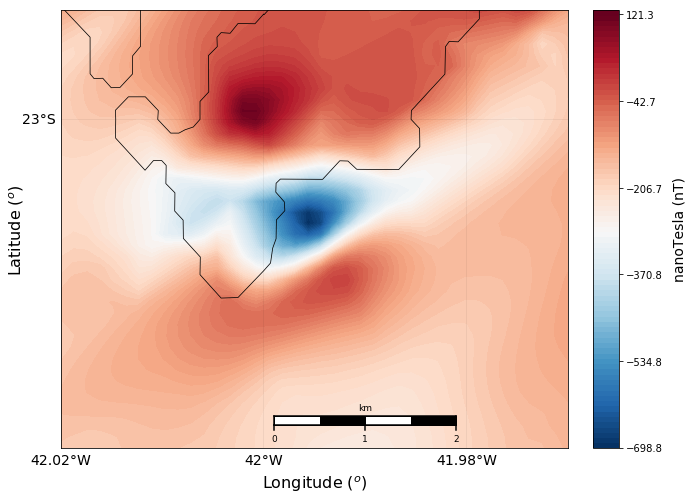

In [32]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(10, 10))

map4.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14, linewidth=0.1)
map4.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14, linewidth=0.1)
map4.drawcoastlines(linewidth = 0.75, color = 'k', linestyle = 'solid')
map4.drawmapscale(-41.99, -23.0275, long0.max(), lati0.max(), 2, barstyle = 'fancy')
cs4 = map4.contourf(long0.reshape(shape), lati0.reshape(shape), tf.reshape(shape), 100, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map4.colorbar(cs4, location = 'right', size = '5%', pad = '5%')
cbar.set_ticks(numpy.linspace(tf.min(), tf.max(), 6))
cbar.set_clim(tf.min(), tf.max())
cbar.set_label('nanoTesla (nT)', fontsize = 14, rotation = 90, labelpad = 10)

pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 25)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 35)

pyplot.savefig('cap05c-figure01.png', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.savefig('cap05c-figure01.pdf', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.show()

For the equivalent layer - vectors: $\left[\bar{xo}, \bar{yo}, \bar{zo}, \bar{tf} \right]$

For the reduction filter - matrixs: $\left[\mathbf{X_o}, \mathbf{Y_o},  \mathbf{Z_o}, \mathbf{TF_o} \right]$

In [59]:
# Reshape the data
Xo = xo.reshape(shape)
Yo = yo.reshape(shape)
Zo = zo.reshape(shape)
TF = tf.reshape(shape)

In [60]:
from codes.filtering import continuation

In [191]:
dadoupward = continuation(Xo, Yo, TF, 1.)

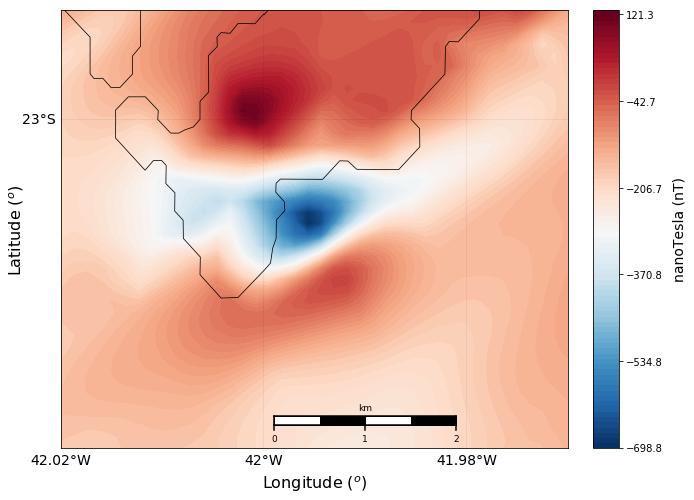

In [192]:
# Plotting the location map
pyplot.close('all')
pyplot.figure(figsize=(10, 10))

map4.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14, linewidth=0.1)
map4.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14, linewidth=0.1)
map4.drawcoastlines(linewidth = 0.75, color = 'k', linestyle = 'solid')
map4.drawmapscale(-41.99, -23.0275, long0.max(), lati0.max(), 2, barstyle = 'fancy')
cs4 = map4.contourf(long0.reshape(shape), lati0.reshape(shape), dadoupward, 100, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map4.colorbar(cs4, location = 'right', size = '5%', pad = '5%')
cbar.set_ticks(numpy.linspace(tf.min(), tf.max(), 6))
cbar.set_clim(tf.min(), tf.max())
cbar.set_label('nanoTesla (nT)', fontsize = 14, rotation = 90, labelpad = 10)

pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 25)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 35)

pyplot.show()

In [193]:
# Loading the magnetic inclination and declination from IGRF
inclination, declination, magfield = numpy.loadtxt('real-data/cabofrio-inc-dec.txt', skiprows = 1,
                                                   delimiter = '\t', usecols = (0, 1, 2), unpack = True)

In [194]:
# Set the inclination and declination values
incf = inclination.mean()
decf = declination.mean()
field = magfield.mean()

In [195]:
print 'Inclination:', incf
print 'Declination:', decf
print 'Magnetic field:', field

Inclination: -36.346359
Declination: -21.825845
Magnetic field: 23472.0925


In [196]:
# Create the equivalent layer
areal = (yo.min() + 1000., yo.max() - 1000., xo.min() + 1500., xo.max() - 1500.)
shapel = (20, 20)
level = 800.
EQL = layer(areal, shapel, level)

In [197]:
# Define the data
datalayer = [yo, xo, zo, dadoupward.reshape(dadoupward.size)]
#datalayer = [yo, xo, zo, tf]

In [198]:
qpo, pred = fit_layer(datalayer, shape, EQL, shapel, 0.4, incf, decf)

In [199]:
# Create the inclination and declination grids
#inc, dec = regular_grid((-90., 90., -90., 90.), (37, 31))
I = numpy.linspace(-90., 90., 31)
D = numpy.linspace(-90., 90., 13)
dec, inc = numpy.meshgrid(D, I)

In [200]:
# Create the zero-array to allocate the results
res =  numpy.zeros_like(dec)

In [201]:
# Import the time computation:
from time import time

In [202]:
# Initial time
time1 = time()
for cols, d in enumerate(D):
    for rows, i in enumerate(I):
        if i >= -15. or i <= 15.:
            rtpdata = rtp_layer(datalayer, shape, EQL, shapel, 0.4, incf, decf, i, d)
            res[rows, cols] = cccoef(totalgrad(Yo, Xo, rtpdata),
                                     zderiv(Yo, Xo, rtpdata))
        else:
            rtpdata = reduction(Yo, Xo, dadoupward, incf, decf, i, d)
            res[rows, cols] = cccoef(totalgrad(Yo, Xo, rtpdata),
                                     zderiv(Yo, Xo, rtpdata))
# Final time
time2 = time()

In [203]:
# Show computation time
print 'Computation time (sec): %.3f' % (time2 - time1)

Computation time (sec): 385.235


In [204]:
# Analysing the positive coefficients
print 'Full cross correlation:'
print 'Minimun:', res.min()
print 'Maximun:', res.max()

Full cross correlation:
Minimun: -0.37280421054724466
Maximun: 0.7845506087445862


In [205]:
# Search for the maximum and minimum pair of inclination and declination
imax, jmax = numpy.where(res == res.max())
imin, jmin = numpy.where(res == res.min())
incmax = float(inc[imax, jmax])
decmax = float(dec[imax, jmax])
incmin = float(inc[imin, jmin])
decmin = float(dec[imin, jmin])
print '(I,D) for maximum coefficient'
print 'Inclination:', incmax
print 'Declination:', decmax

(I,D) for maximum coefficient
Inclination: 12.0
Declination: -30.0


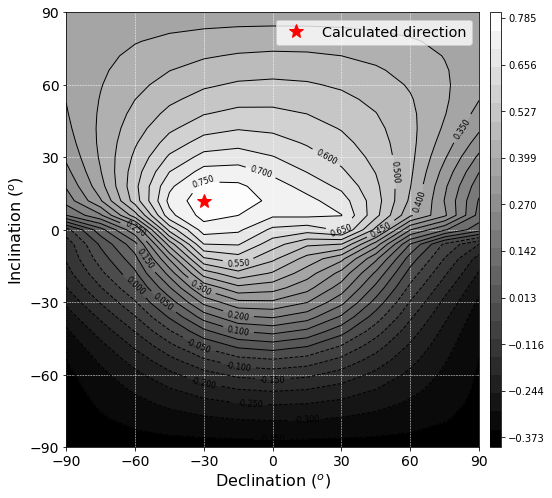

In [206]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 8))
# Line contour
c1 = pyplot.contour(dec, inc, res, 25, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 8)
c2 = pyplot.contourf(dec, inc, res, 25, vmin = res.min(), vmax = res.max(), cmap = pyplot.cm.gray)
cbar2 = pyplot.colorbar(c2, aspect = 40, fraction = 0.05, orientation = 'vertical', pad = 0.025)
cbar2.set_ticks(numpy.linspace(res.min(), res.max(), 10))
cbar2.set_clim(res.min(), res.max())
pyplot.plot(decmax, incmax, 'r*', label = 'Calculated direction', markersize = 14)
pyplot.xlabel('Declination $(^o)$', fontsize = 16)
pyplot.ylabel('Inclination $(^o)$', fontsize = 16)
pyplot.xticks(numpy.linspace(dec.min(), dec.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inc.min(), inc.max(), 7), fontsize = 14)
pyplot.legend(loc = 'best', fontsize = 'x-large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 0.5)

#pyplot.savefig('cap05c-figure02.png', dpi = 300, transparent = True, bbox_inches = 'tight')
#pyplot.savefig('cap05c-figure02.pdf', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [207]:
# Create the new grids to interpolate
area2interp = (I.min(), I.max(), D.min(), D.max())
shape2interp = (181, 181)
INC, DEC = regular_grid(area2interp, shape2interp)

In [208]:
R = res.reshape(res.size)

In [209]:
# Interpolate the result
RES = griddata((inc.reshape(inc.size), dec.reshape(dec.size)), R, (INC, DEC), method = 'cubic', rescale=True)

In [210]:
# Reshape the interpolated result
DEC = DEC.reshape(shape2interp)
INC = INC.reshape(shape2interp)
RES = RES.reshape(shape2interp)

In [211]:
# Search for the interpolated result
p1, p2 = numpy.where(RES == RES.max())
pimax = float(INC[p1, p2])
pdmax = float(DEC[p1, p2])
print '(I,D) for maximum coefficient'
print 'Inclination:', pimax
print 'Declination:', pdmax

(I,D) for maximum coefficient
Inclination: 11.0
Declination: -27.0


In [212]:
# Defines the colorbar
ccmin = RES.min()
ccmax = RES.max()

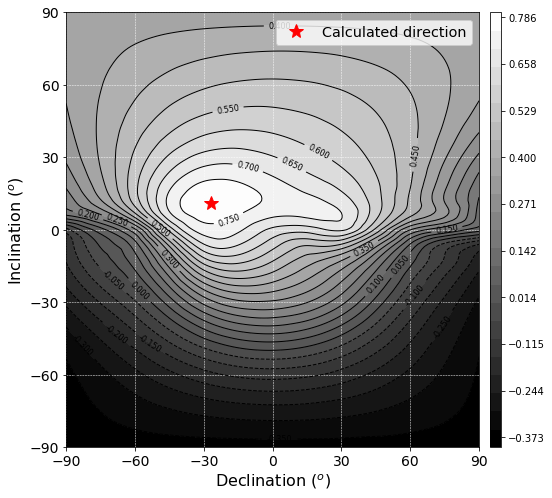

In [213]:
# Plotting the cross correlation results
pyplot.figure(figsize=(8, 8))
c1 = pyplot.contour(DEC, INC, RES, 25, colors = 'k', linestyle = 'solid', linewidths = 1)
pyplot.clabel(c1, fontsize = 8)
c2 = pyplot.contourf(DEC.reshape(shape2interp), INC.reshape(shape2interp), RES.reshape(shape2interp), 
                     25, vmin = ccmin, vmax = ccmax, cmap = pyplot.cm.gray)
cbar2 = pyplot.colorbar(c2, aspect = 40, fraction = 0.05, orientation = 'vertical', pad = 0.025)
cbar2.set_ticks(numpy.linspace(ccmin, ccmax, 10))
cbar2.set_clim(ccmin, ccmax)
pyplot.plot(pdmax, pimax, 'r*', label = 'Calculated direction', markersize = 14)
pyplot.xlabel('Declination $(^o)$', fontsize = 16)
pyplot.ylabel('Inclination $(^o)$', fontsize = 16)
pyplot.xticks(numpy.linspace(dec.min(), dec.max(), 7), fontsize = 14)
pyplot.yticks(numpy.linspace(inc.min(), inc.max(), 7), fontsize = 14)
pyplot.legend(loc = 'best', fontsize = 'x-large')

pyplot.grid(color = 'w', linestyle = '--', linewidth = 0.5)

#pyplot.savefig('cap05c-figure03.png', dpi = 300, transparent = True, bbox_inches = 'tight')
#pyplot.savefig('cap05c-figure03.pdf', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [233]:
# Calculates the RTP data
Rtp = rtp_layer(datalayer, shape, EQL, shapel, 0.001, incf, decf, pimax, pdmax)

In [234]:
'''
xoplot, yoplot, = regular_grid((xo.min(), xo.max(), yo.min(), yo.max()), (250, 250))
Rtpi = griddata((yo, xo), Rtp.reshape(Rtp.size), (yoplot, xoplot), method = 'cubic')
Rtpiup = griddata((yo, xo), Rtpup.reshape(Rtp.size), (yoplot, xoplot), method = 'cubic')
plotx = xoplot.reshape(250, 250)
ploty = yoplot.reshape(250, 250)
plotz = Rtpi.reshape(250, 250)
plotzup = Rtpiup.reshape(250, 250)
'''

"\nxoplot, yoplot, = regular_grid((xo.min(), xo.max(), yo.min(), yo.max()), (250, 250))\nRtpi = griddata((yo, xo), Rtp.reshape(Rtp.size), (yoplot, xoplot), method = 'cubic')\nRtpiup = griddata((yo, xo), Rtpup.reshape(Rtp.size), (yoplot, xoplot), method = 'cubic')\nplotx = xoplot.reshape(250, 250)\nploty = yoplot.reshape(250, 250)\nplotz = Rtpi.reshape(250, 250)\nplotzup = Rtpiup.reshape(250, 250)\n"

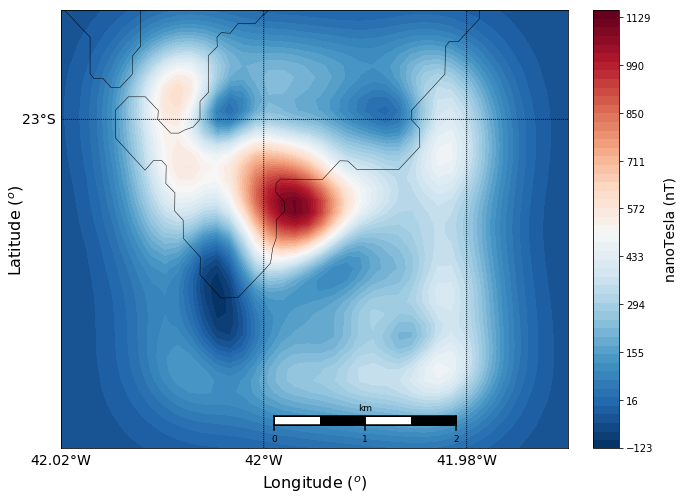

In [235]:
pyplot.figure(figsize=(10,10))
map4.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14)
map4.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14)
map4.drawcoastlines(linewidth = 0.5, color = 'k', linestyle = 'solid')
map4.drawmapscale(-41.99, -23.0275, long0.max(), lati0.max(), 2, barstyle = 'fancy')
cs3 = map4.contourf(long0.reshape(shape), lati0.reshape(shape), Rtp.reshape(shape), 50, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map4.colorbar(cs3, location = 'right', size = '5%', pad = '5%')
cbar.set_ticks(numpy.linspace(Rtp.min(), Rtp.max(), 10))
cbar.set_clim(Rtp.min(), Rtp.max())
cbar.set_label('nanoTesla (nT)', fontsize = 14, rotation = 90, labelpad = 10)

pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 25)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 35)

pyplot.savefig('cap05c-figure04.png', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.savefig('cap05c-figure04.pdf', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.show()

In [236]:
rtpup = continuation(Xo, Yo, Rtp, 200)

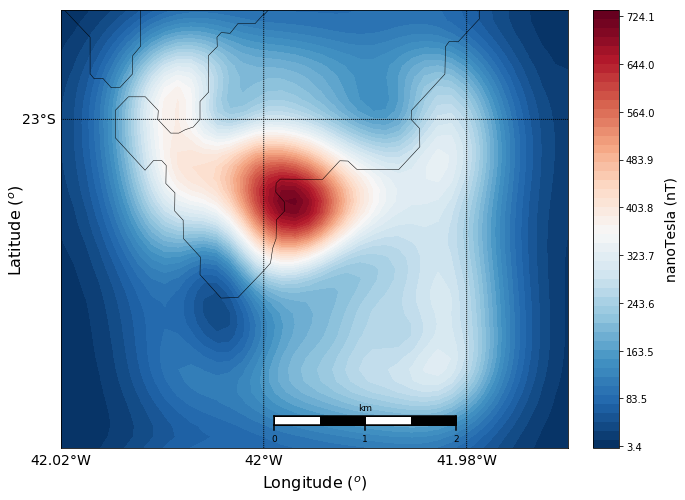

In [237]:
pyplot.figure(figsize=(10,10))
map4.drawmeridians(meridians2, labels=[1, 0, 0, 1], fontsize = 14)
map4.drawparallels(parallels2, labels=[1, 0, 0, 1], fontsize = 14)
map4.drawcoastlines(linewidth = 0.5, color = 'k', linestyle = 'solid')
map4.drawmapscale(-41.99, -23.0275, long0.max(), lati0.max(), 2, barstyle = 'fancy')
cs3 = map4.contourf(long0.reshape(shape), lati0.reshape(shape), rtpup.reshape(shape), 50, 
                    cmap = pyplot.cm.RdBu_r, latlon = True, alpha = 1.)
cbar = map4.colorbar(cs3, location = 'right', size = '5%', pad = '5%')
cbar.set_ticks(numpy.linspace(rtpup.min(), rtpup.max(), 10))
cbar.set_clim(rtpup.min(), rtpup.max())
cbar.set_label('nanoTesla (nT)', fontsize = 14, rotation = 90, labelpad = 10)

pyplot.xlabel('Longitude $(^o)$', fontsize = 16, labelpad = 25)
pyplot.ylabel('Latitude $(^o)$', fontsize = 16, labelpad = 35)

#pyplot.savefig('cap05c-figure04.png', dpi = 300, transparent = True, bbox_inches = 'tight')
#pyplot.savefig('cap05c-figure04.pdf', dpi = 300, transparent = True, bbox_inches = 'tight')
pyplot.show()